In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math

from IPython import display

from scipy.linalg import fractional_matrix_power

tfd = tf.contrib.distributions

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [50]:
fire_evac_train = np.load('FireEvac_train_set.npy')
fire_evac_test = np.load('FireEvac_test_set.npy')

fire_evac_train = (fire_evac_train - fire_evac_train.mean(axis=0)) / fire_evac_train.std(axis=0)
fire_evac_test = (fire_evac_test - fire_evac_test.mean(axis=0)) / fire_evac_test.std(axis=0)

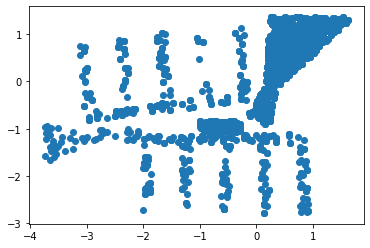

In [51]:
plt.scatter(fire_evac_train[:,0],fire_evac_train[:,1])

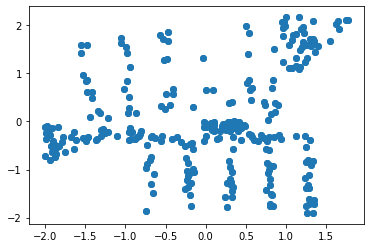

In [52]:
plt.scatter(fire_evac_test[:,0],fire_evac_test[:,1])

Epoch 0 elbo -7.604201
Epoch 1 elbo -3.754023
Epoch 2 elbo -3.3354757
Epoch 3 elbo -3.1345928
Epoch 4 elbo -3.046534
Epoch 5 elbo -2.9991035
Epoch 6 elbo -2.994215
Epoch 7 elbo -2.995698
Epoch 8 elbo -3.0161169
Epoch 9 elbo -3.0907578


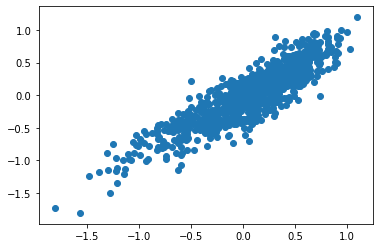

Epoch 10 elbo -3.036624
Epoch 11 elbo -2.998716
Epoch 12 elbo -3.081347
Epoch 13 elbo -3.0719316
Epoch 14 elbo -3.0891287
Epoch 15 elbo -3.0983455
Epoch 16 elbo -3.2295732
Epoch 17 elbo -3.2026749
Epoch 18 elbo -3.0291963
Epoch 19 elbo -3.0698087


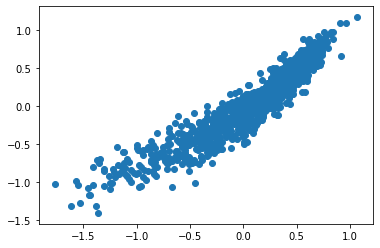

Epoch 20 elbo -3.0877986
Epoch 21 elbo -3.175113
Epoch 22 elbo -3.0573483
Epoch 23 elbo -3.0241141
Epoch 24 elbo -3.106851
Epoch 25 elbo -3.1657937
Epoch 26 elbo -3.010546
Epoch 27 elbo -3.0106528
Epoch 28 elbo -3.0990572
Epoch 29 elbo -3.0957844


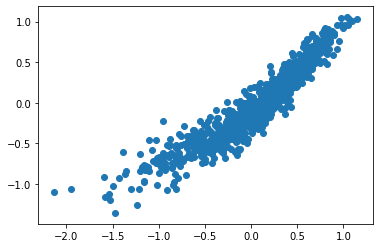

Epoch 30 elbo -3.1911309
Epoch 31 elbo -3.1291778
Epoch 32 elbo -3.076235
Epoch 33 elbo -3.147666
Epoch 34 elbo -3.2048507
Epoch 35 elbo -3.2441554
Epoch 36 elbo -3.0943444
Epoch 37 elbo -3.112883
Epoch 38 elbo -3.0924394
Epoch 39 elbo -3.0716145


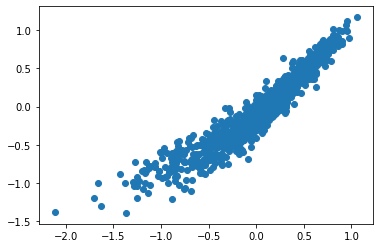

Epoch 40 elbo -3.1273184
Epoch 41 elbo -3.122014
Epoch 42 elbo -3.1533098
Epoch 43 elbo -3.172309
Epoch 44 elbo -3.1807263
Epoch 45 elbo -3.1572692
Epoch 46 elbo -3.1036522
Epoch 47 elbo -3.1990821
Epoch 48 elbo -3.2888079
Epoch 49 elbo -3.2584672


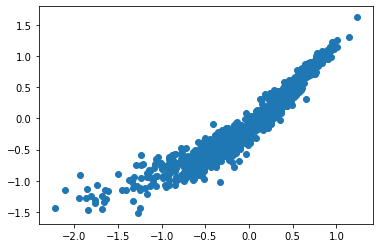

In [65]:
def make_encoder(data, code_size):
    x = tf.layers.flatten(data)
    x = tf.layers.dense(x, 64, tf.nn.relu)
    x = tf.layers.dense(x, 64, tf.nn.relu)
    loc = tf.layers.dense(x, code_size)
    scale = tf.layers.dense(x, code_size, tf.nn.softplus)
    return tfd.MultivariateNormalDiag(loc, scale)


def make_prior(code_size):
    loc = tf.zeros(code_size)
    scale = tf.ones(code_size)
    return tfd.MultivariateNormalDiag(loc, scale)


def make_decoder(code, data_shape):
    x = code
    x = tf.layers.dense(x, 64, tf.nn.relu)
    x = tf.layers.dense(x, 64, tf.nn.relu)
    loc = tf.layers.dense(x, data_shape)
    scale = tf.layers.dense(x, data_shape, tf.nn.softplus)
    return tfd.MultivariateNormalDiag(loc, scale)

data = tf.placeholder(tf.float32, [None, 2])
code_size = 32
make_encoder = tf.make_template('encoder', make_encoder)
make_decoder = tf.make_template('decoder', make_decoder)

# Define the model.
prior = make_prior(code_size=code_size)
posterior = make_encoder(data, code_size=code_size)
code = posterior.sample()

# Define the loss.
likelihood = make_decoder(code, 2).log_prob(data)
divergence = tfd.kl_divergence(posterior, prior)
elbo = tf.reduce_mean(likelihood - divergence)
optimize = tf.train.AdamOptimizer(0.001).minimize(-elbo)

samples = make_decoder(prior.sample(1000), 2).mean()

def plot_samples(samples):
    plt.scatter(samples[:,0], samples[:,1])
    plt.show()

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for epoch in range(50):
    feed = {data: fire_evac_test}
    test_elbo, test_samples = sess.run([elbo, samples], feed)
    print('Epoch', epoch, 'elbo', test_elbo)
    if (epoch + 1) % 10 == 0:
        plot_samples(test_samples)
    for i in range(50):
        dim_st = i*64
        dim_end = dim_st+64
        feed = {data: fire_evac_train[dim_st: dim_end]}
        sess.run(optimize, feed)